# 1. Import Library

In [106]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import boxcox
from sklearn.preprocessing import LabelEncoder

figsize = (12, 8)

# 2. Reading Data

In [107]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')

# 3. Data Overview
- Về Shape:
    - Dữ liệu lớn cỡ nào?
- Về Data Types:
    - Dữ liệu định dạng đúng chưa?
- Về **ý nghĩa**:
    - Một dòng đại diện cho cái gì?

## Detail columns
- **id**: Mã định danh của khách hàng
- **annual_income**: Thu nhập hàng năm của người vay (USD)
- **debt_to_income_ratio**: Tỉ lệ nợ trên thu nhập (DTI). Các điều kiện tiên quyết:
    - **Dưới 36%**: Tốt
    - **36% - 49%**: Trung bình
    - **Trên 49%**: Xấu
- **credit_score**: Điểm tín dụng (điểm càng cao thì càng tốt)
- **loan_amount**: Tổng tiền vay
- **interest_rate**: Lãi suất vay
- **gender**: Giới tính
- **marial_status**: Tình trạng hôn nhân
- **education_level**: Trình độ học vấn
- **employment_status**: Tình trạng việc làm
- **loan_purpose**: Mục đích vay
- **grade_subgrade**: Hạng tín dụng
- **loan_paid_back**: Trạng thái trả nợ

In [108]:
shape = train.shape
print(f"Rows: {shape[0]} - Columns: {shape[1]}")

Rows: 593994 - Columns: 13


In [109]:
train.dtypes

id                        int64
annual_income           float64
debt_to_income_ratio    float64
credit_score              int64
loan_amount             float64
interest_rate           float64
gender                   object
marital_status           object
education_level          object
employment_status        object
loan_purpose             object
grade_subgrade           object
loan_paid_back          float64
dtype: object

In [110]:
train.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


- Từng dòng chính là thông tin của một người về thu nhập và số tiền vay, cũng như điểm tín dụng và các thông tin khác. Đặc biệt là người đó có trả nợ hay vỡ nợ

# 4. Data Preparation
- Missing Values
- Duplicated Value
- Dropping irrelevant columns or rows
- Change Name

### Check missing and duplicate

In [111]:
is_null = all(train.isnull().sum() != 0)
is_duplicated = int(train.duplicated().sum()) != 0

print(f"Data is null? -> {is_null}\nData is duplicated? -> {is_duplicated}")

Data is null? -> False
Data is duplicated? -> False


- Dữ liệu không bị Null hoặc không bị duplicated
- Việc tiếp theo sẽ là bỏ bớt các cột không sử dụng

### Drop irrelevant columns

In [112]:
train = train[['annual_income', 'debt_to_income_ratio', 'credit_score',
       'loan_amount',
       'education_level', 'employment_status', 'loan_purpose',
       'grade_subgrade', 'loan_paid_back']]

### Change Name

In [113]:
train.rename(columns={
    "annual_income": "Annual Income",
    "debt_to_income_ratio": "DTI ratio",
    "credit_score": "Credit Score",
    "loan_amount": "Loan Amount",
    "education_level": "Education",
    "employment_status": "Employment",
    "loan_purpose": "Purpose",
    "grade_subgrade": "Grade",
    "loan_paid_back": "Loan Paid Back"
}, inplace=True)

In [114]:
train.head()

,Annual Income,DTI ratio,Credit Score,Loan Amount,Education,Employment,Purpose,Grade,Loan Paid Back
0,29367.99,0.084,736,2528.42,High School,Self-employed,Other,C3,1.0
1,22108.02,0.166,636,4593.10,Master's,Employed,Debt consolidation,D3,0.0
2,49566.20,0.097,694,17005.15,High School,Employed,Debt consolidation,C5,1.0
3,46858.25,0.065,533,4682.48,High School,Employed,Debt consolidation,F1,1.0
4,25496.70,0.053,665,12184.43,High School,Employed,Other,D1,1.0


# 5. EDA

## 5.1 Feature Understanding
- **Numerical Variable:**
    - **Distribution:** Dữ liệu có bị lệch (skewed) hay phân phối chuẩn (normal)?
    - **Outliers:** Có giá trị outliers không?
- **Categorical:**
    - **Imbalanced:** Có bị chiếm áp đảo không?

### 5.1.A Numerical Variable

In [115]:
numerical_data = train[['Annual Income', 'DTI ratio', "Credit Score", "Loan Amount"]]

#### Distribution

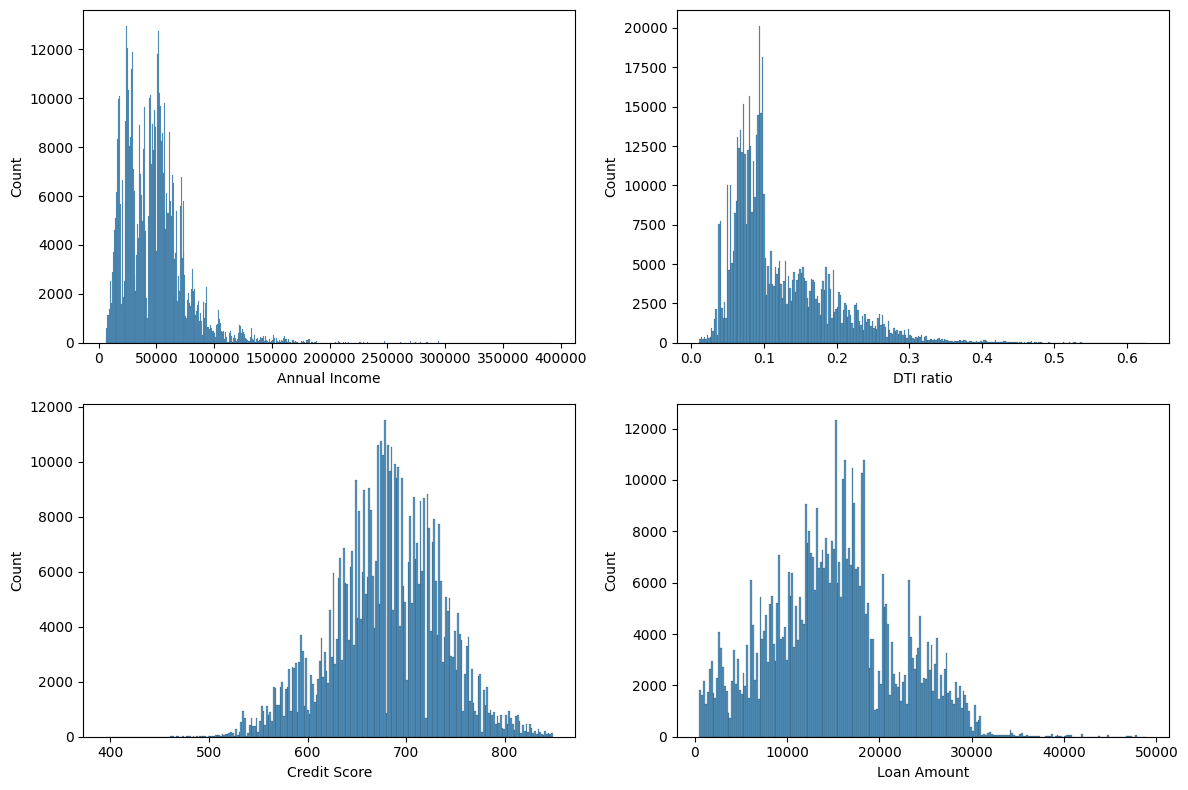

In [116]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=figsize)

sns.histplot(numerical_data, x='Annual Income', ax=ax[0, 0])
sns.histplot(numerical_data, x='DTI ratio', ax=ax[0, 1])
sns.histplot(numerical_data, x='Credit Score', ax=ax[1, 0])
sns.histplot(numerical_data, x='Loan Amount', ax=ax[1, 1])

fig.tight_layout()
plt.show()

- **Annual Income** đang bị lệch về trái &rarr; hầu hết đều là người thu nhập thấp và trung bình
- **DTI ratio** đang lệch về trái &rarr; đây là tín hiệu rất tốt vì khả năng trả nợ là rất cao
- **Credit Score** đang lệch về phải &rarr; có sự tương đồng với **DTI ratio** (Điểm càng cao càng tốt và nó ngược lại với DTI)
- **Loan Amount** lệch trái một cút &rarr; hầu hết mọi người đang vay nợ tầm trung

#### Outliers

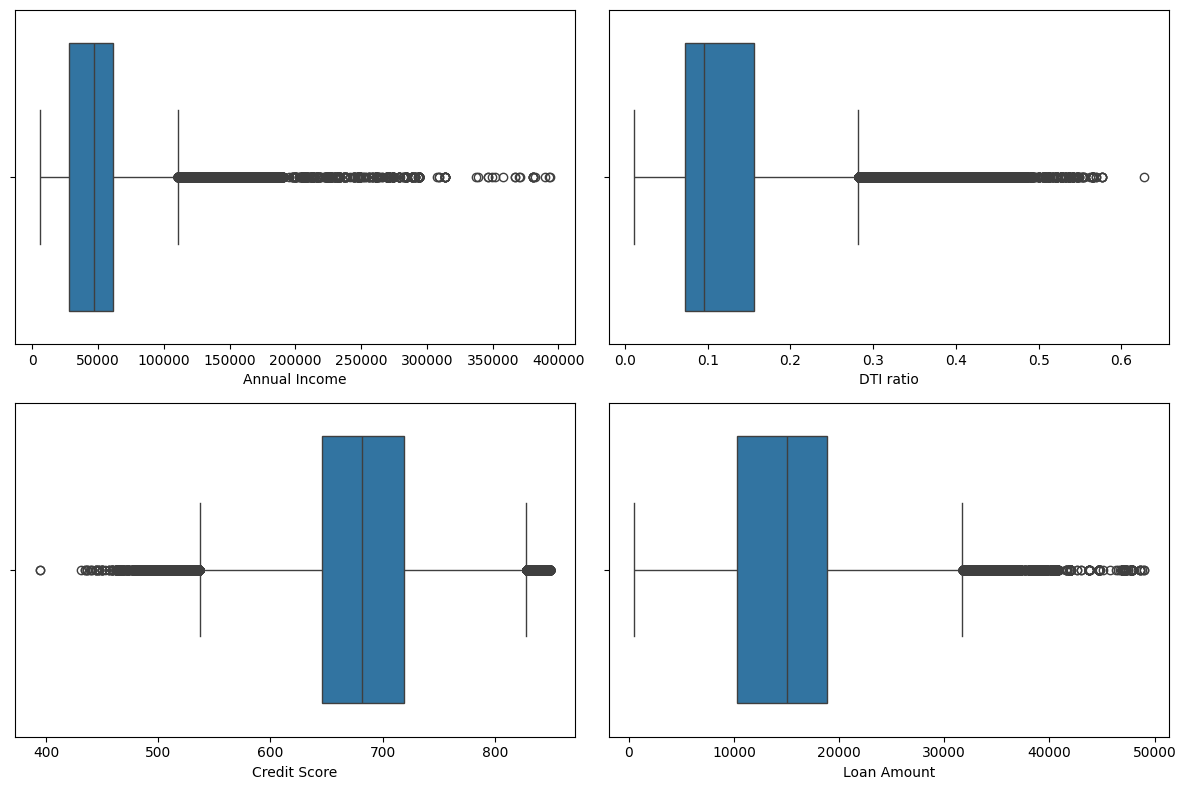

In [117]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=figsize)

sns.boxplot(numerical_data, x='Annual Income', ax=ax[0, 0])
sns.boxplot(numerical_data, x='DTI ratio', ax=ax[0, 1])
sns.boxplot(numerical_data, x='Credit Score', ax=ax[1, 0])
sns.boxplot(numerical_data, x='Loan Amount', ax=ax[1, 1])

fig.tight_layout()
plt.show()

- **Annual Income** đang có rất nhiều outliers (Có nên cắt bỏ các outliers này không?)
- **Other** đều có Outliers nhưng tạm chấp nhận được (Rất ít)

### 5.1.B Categorical

In [118]:
categorical_data = train[['Education', 'Employment', 'Purpose', 'Grade']]

#### Cardinality

In [119]:
print(f"Unique class in Education: {list(categorical_data['Education'].unique())}")
print(f"Unique class in Employment: {list(categorical_data['Employment'].unique())}")
print(f"Unique class in Purpose: {list(categorical_data['Purpose'].unique())}")
print(f"Unique class in Grade: {list(categorical_data['Grade'].unique())}")

Unique class in Education: ['High School', "Master's", "Bachelor's", 'PhD', 'Other']
Unique class in Employment: ['Self-employed', 'Employed', 'Unemployed', 'Retired', 'Student']
Unique class in Purpose: ['Other', 'Debt consolidation', 'Home', 'Education', 'Vacation', 'Car', 'Medical', 'Business']
Unique class in Grade: ['C3', 'D3', 'C5', 'F1', 'D1', 'D5', 'C2', 'C1', 'F5', 'D4', 'C4', 'D2', 'E5', 'B1', 'B2', 'F4', 'A4', 'E1', 'F2', 'B4', 'E4', 'B3', 'E3', 'B5', 'E2', 'F3', 'A5', 'A3', 'A1', 'A2']


- Vì Grade chiếm ưu thế và có thứ tự nên sẽ sắp xếp lại theo thứ tự bên grade

In [120]:
categorical_data.sort_values(by=['Grade'], axis=0, inplace=True)

C:\Users\hungm\AppData\Local\Temp\ipykernel_23164\1913654876.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_data.sort_values(by=['Grade'], axis=0, inplace=True)


#### Distribution

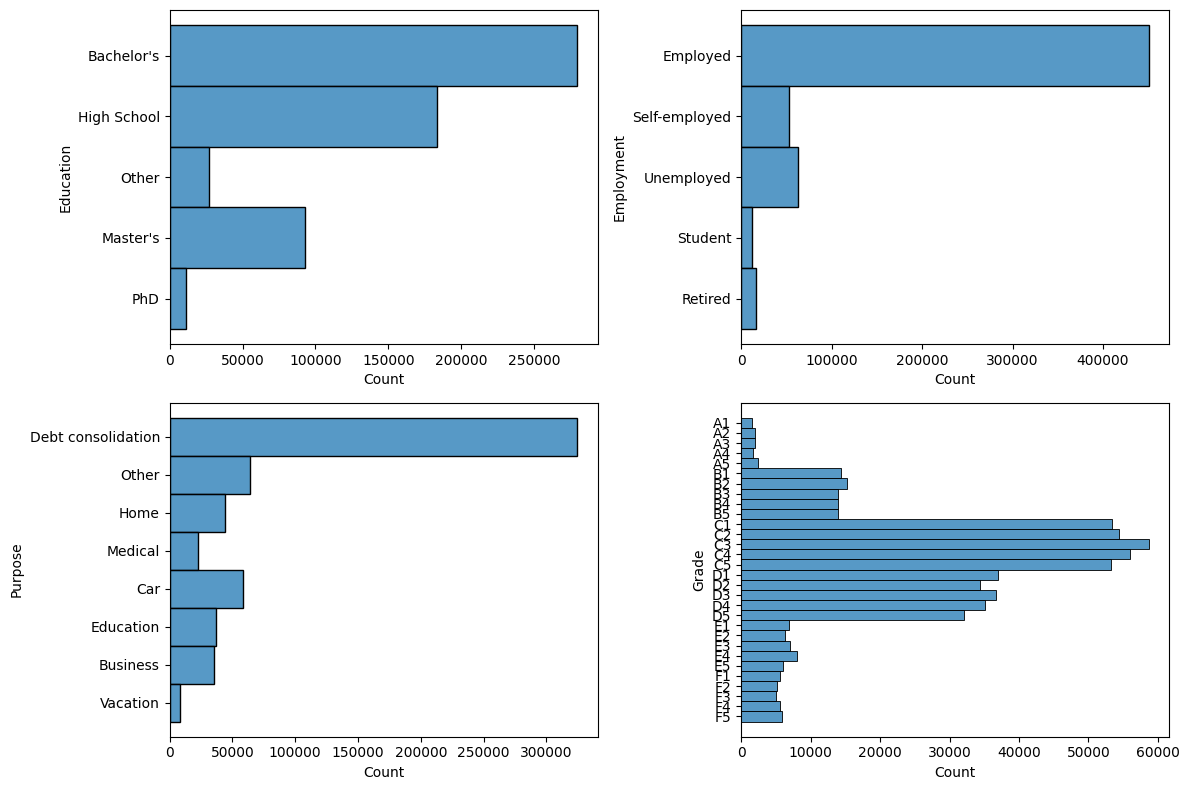

In [121]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=figsize)

sns.histplot(categorical_data, y='Education', ax=ax[0, 0])
sns.histplot(categorical_data, y='Employment', ax=ax[0, 1])
sns.histplot(categorical_data, y='Purpose', ax=ax[1, 0])
sns.histplot(categorical_data, y='Grade', ax=ax[1, 1])

fig.tight_layout()
plt.show()

- **Education:** Hầu hết đều là Banchelor và High School
- **Employment:** Chiếm phần lớn nhất là Employed
- **Purpose:** Mục đích chiếm nhiều nhất là Debt consolidation
- **Grade:** Đa số mọi người đều có mức hạng trung bình, hạng tốt chỉ chiếm rất ít, còn lại là hạng thấp (đa số không thể trả)

## 5.2 Feature Relationship
- Correlation
- **Relationship with Target**

### Correlation

<Axes: >

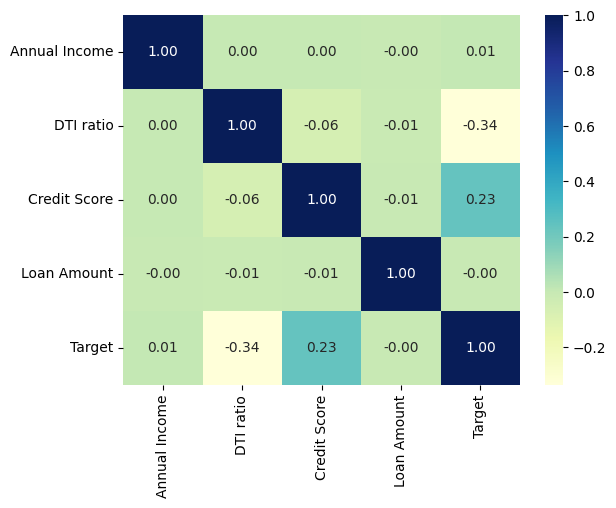

In [122]:
# Numerical

df_corr = numerical_data.copy()
df_corr['Target'] = train['Loan Paid Back']
df_corr = df_corr.corr()

sns.heatmap(df_corr, annot=True, fmt='.2f', cmap="YlGnBu")

- Như đã đề cập ở trên, Khả năng trả nợ có sự tương quan với **DTI và Credit Score**.
    - **DTI:** tỉ lệ nghịch với Target (DTI càng thấp thì khả năng trả nợ càng cao và ngược lại)
    - **Credit Score:** tỉ lệ thuận với Target (Credit Score càng cao thì khả năng trả nợ càng cao và ngược lại)

&rarr; Đây chính là 2 feature cực kì quan trọng

### Relationship with Target

#### Numerical

<Axes: xlabel='Loan Paid Back', ylabel='Credit Score'>

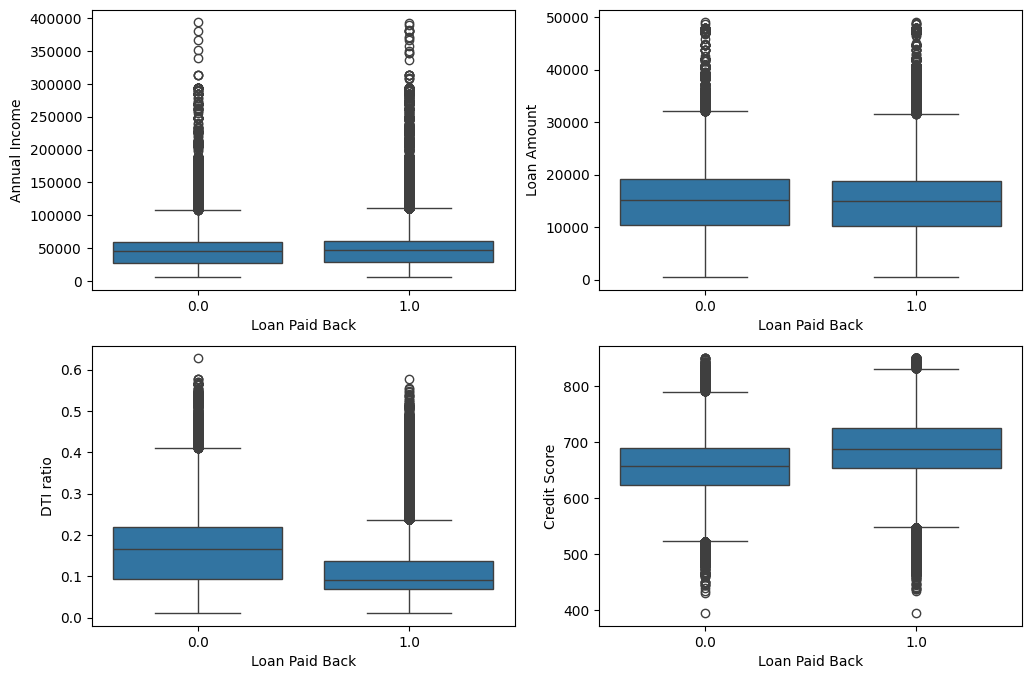

In [123]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=figsize)

sns.boxplot(train, x='Loan Paid Back', y='Annual Income', ax=ax[0, 0])
sns.boxplot(train, x='Loan Paid Back', y='Loan Amount', ax=ax[0, 1])
sns.boxplot(train, x='Loan Paid Back', y='DTI ratio', ax=ax[1, 0])
sns.boxplot(train, x='Loan Paid Back', y='Credit Score', ax=ax[1, 1])

- **Annual Income** và **Loan Amount** có mức chênh lệch là như nhau (Có thể biến đổi 2 feature này lại)
- **DTI ratio** và **Credit Score** có mức chệnh lệch rõ ràng, tuy nhiên có rất nhiều outliers (xem xét để bỏ chúng nếu không cần thiết)

#### Categories

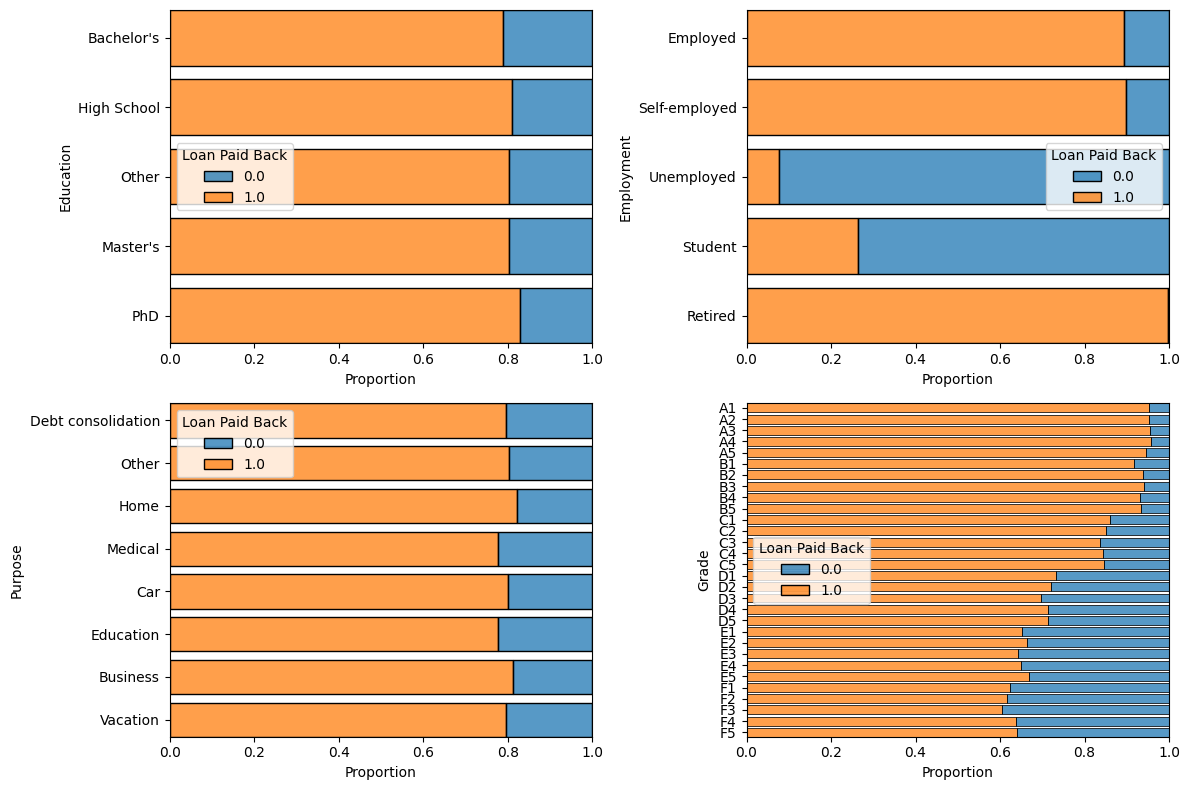

In [124]:
# Stacked Bar
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=figsize)

stacked_data = train.copy().sort_values(by='Grade')

sns.histplot(stacked_data, y='Education', hue='Loan Paid Back', multiple='fill', stat='proportion', discrete=True, shrink=.8, ax=ax[0, 0])
sns.histplot(stacked_data, y='Employment', hue='Loan Paid Back', multiple='fill', stat='proportion', discrete=True, shrink=.8, ax=ax[0, 1])
sns.histplot(stacked_data, y='Purpose', hue='Loan Paid Back', multiple='fill', stat='proportion', discrete=True, shrink=.8, ax=ax[1, 0])
sns.histplot(stacked_data, y='Grade', hue='Loan Paid Back', multiple='fill', stat='proportion', discrete=True, shrink=.8, ax=ax[1, 1])

fig.tight_layout()

- **Education** và **Purpose** Tỉ lệ trả nợ là ngang nhau (Feature không quan trọng)
- **Employment:** Người có việc, tự làm và nghỉ hưu có tỉ lệ trả nợ cao hơn nhóm người là học sinh và thất nghiệp
- **Grade:** Thứ hạng có sự giảm dần từ hạng cao nhất là A đến F. Thứ hạng càng cao thì khả năng trả nợ cũng tăng lên

#### Tổng kết:
- Các feature quan trọng:
    1. **DTI ratio**
    2. **Credit Score**
    3. **Employment**
    4. **Grade**
    5. **Loan/Income ratio**
- Câu hỏi tiếp theo: Cần xử lý Outliers như thế nào?

## 5.3 Analysis Outliers

In [125]:
train.describe()

,Annual Income,DTI ratio,Credit Score,Loan Amount,Loan Paid Back
count,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000
mean,48212.202976,0.120696,680.916009,15020.297629,0.798820
std,26711.942078,0.068573,55.424956,6926.530568,0.400883
min,6002.430000,0.011000,395.000000,500.090000,0.000000
25%,27934.400000,0.072000,646.000000,10279.620000,1.000000
50%,46557.680000,0.096000,682.000000,15000.220000,1.000000
75%,60981.320000,0.156000,719.000000,18858.580000,1.000000
max,393381.740000,0.627000,849.000000,48959.950000,1.000000


### Get data from Q1, IQR and Q3

##### A. Analysis Outliers Annual Income

In [126]:
q3_income = train.describe()['Annual Income']['75%'].item()

outliers_data = train.loc[train['Annual Income'] > q3_income]
outliers_data.describe()

,Annual Income,DTI ratio,Credit Score,Loan Amount,Loan Paid Back
count,148467.000000,148467.000000,148467.000000,148467.000000,148467.000000
mean,82522.239888,0.120252,680.680218,14995.792600,0.806745
std,25833.488135,0.067205,54.884015,6943.378493,0.394853
min,60981.420000,0.011000,395.000000,500.090000,0.000000
25%,65884.720000,0.072000,646.000000,10359.075000,1.000000
50%,73375.300000,0.096000,682.000000,14818.080000,1.000000
75%,88529.630000,0.157000,718.000000,18793.730000,1.000000
max,393381.740000,0.577000,849.000000,47865.220000,1.000000


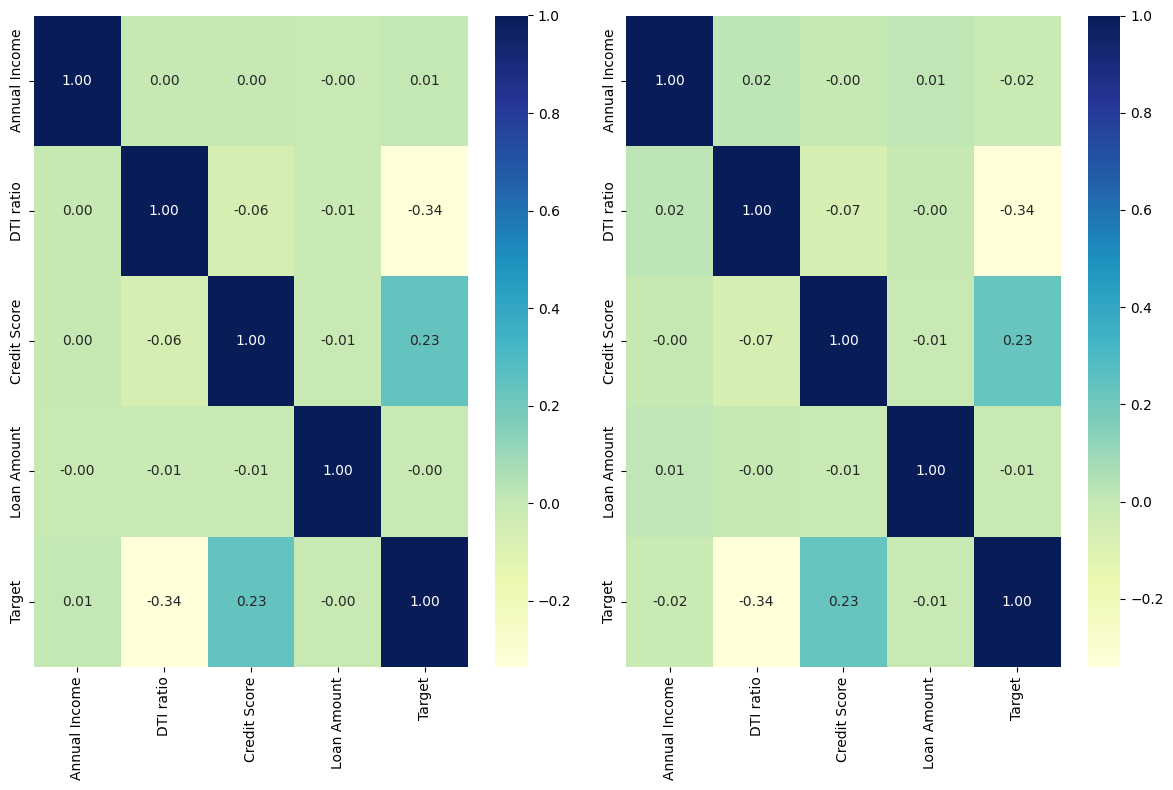

In [127]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=figsize)

numerical_data_outliers = outliers_data[['Annual Income', 'DTI ratio', "Credit Score", "Loan Amount"]]

df_outliers_income_corr = numerical_data_outliers.copy()
df_outliers_income_corr['Target'] = outliers_data['Loan Paid Back']
df_outliers_income_corr = df_outliers_income_corr.corr()

sns.heatmap(df_corr, annot=True, fmt='.2f', cmap="YlGnBu", ax=ax[0])
sns.heatmap(df_outliers_income_corr, annot=True, fmt='.2f', cmap="YlGnBu", ax=ax[1])

fig.tight_layout()

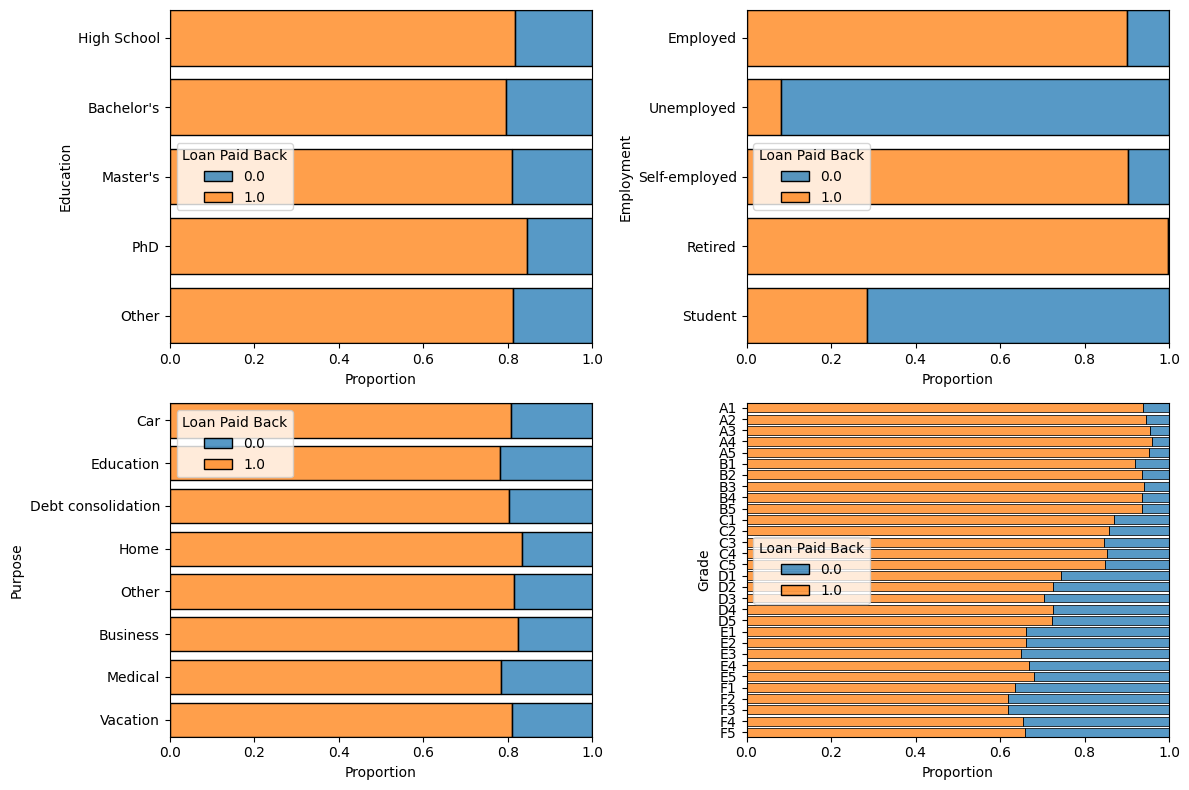

In [128]:
# Stacked Bar
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=figsize)

stacked_data = outliers_data.copy().sort_values(by='Grade')

sns.histplot(stacked_data, y='Education', hue='Loan Paid Back', multiple='fill', stat='proportion', discrete=True, shrink=.8, ax=ax[0, 0])
sns.histplot(stacked_data, y='Employment', hue='Loan Paid Back', multiple='fill', stat='proportion', discrete=True, shrink=.8, ax=ax[0, 1])
sns.histplot(stacked_data, y='Purpose', hue='Loan Paid Back', multiple='fill', stat='proportion', discrete=True, shrink=.8, ax=ax[1, 0])
sns.histplot(stacked_data, y='Grade', hue='Loan Paid Back', multiple='fill', stat='proportion', discrete=True, shrink=.8, ax=ax[1, 1])

fig.tight_layout()

##### B. Analysis Outliers Loan Amount

In [129]:
q3_loan = train.describe()['Loan Amount']['75%'].item()

outliers_data = train.loc[train['Loan Amount'] > q3_loan]
outliers_data.describe()

,Annual Income,DTI ratio,Credit Score,Loan Amount,Loan Paid Back
count,148496.000000,148496.000000,148496.000000,148496.000000,148496.000000
mean,47974.954895,0.121037,680.456955,24159.797125,0.793705
std,26757.423061,0.069039,55.772760,3588.807034,0.404646
min,6074.920000,0.011000,395.000000,18859.300000,0.000000
25%,27881.830000,0.072000,646.000000,20995.360000,1.000000
50%,45911.220000,0.096000,682.000000,23864.300000,1.000000
75%,60959.170000,0.156000,719.000000,26368.050000,1.000000
max,393381.740000,0.564000,849.000000,48959.950000,1.000000


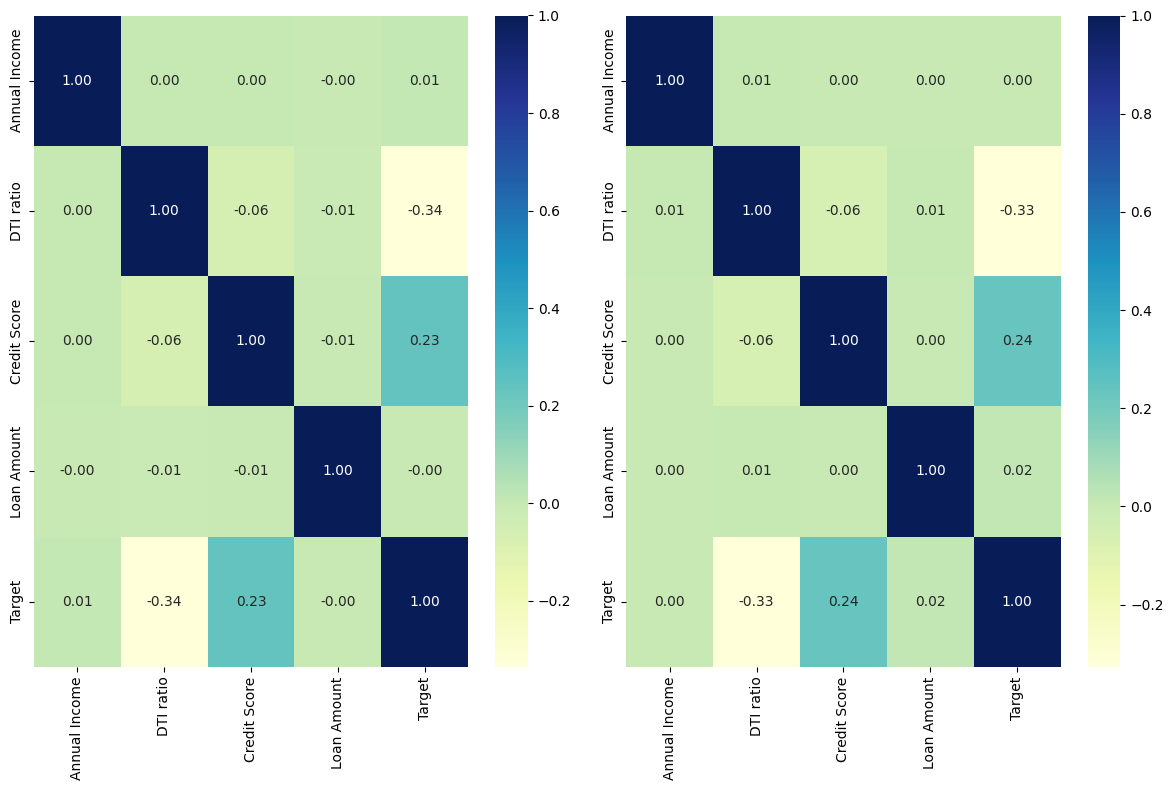

In [130]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=figsize)

numerical_data_outliers = outliers_data[['Annual Income', 'DTI ratio', "Credit Score", "Loan Amount"]]

df_outliers_loan_corr = numerical_data_outliers.copy()
df_outliers_loan_corr['Target'] = outliers_data['Loan Paid Back']
df_outliers_loan_corr = df_outliers_loan_corr.corr()

sns.heatmap(df_corr, annot=True, fmt='.2f', cmap="YlGnBu", ax=ax[0])
sns.heatmap(df_outliers_loan_corr, annot=True, fmt='.2f', cmap="YlGnBu", ax=ax[1])

fig.tight_layout()

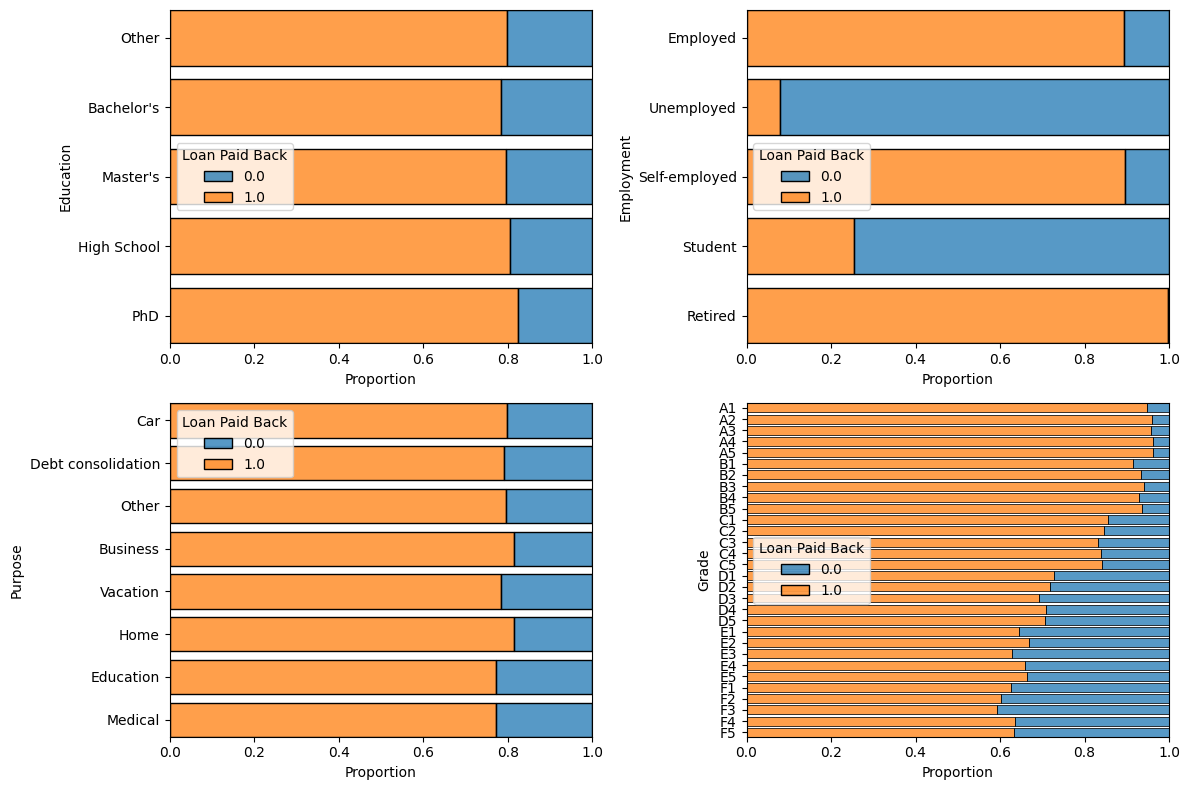

In [131]:
# Stacked Bar
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=figsize)

stacked_data = outliers_data.copy().sort_values(by='Grade')

sns.histplot(stacked_data, y='Education', hue='Loan Paid Back', multiple='fill', stat='proportion', discrete=True, shrink=.8, ax=ax[0, 0])
sns.histplot(stacked_data, y='Employment', hue='Loan Paid Back', multiple='fill', stat='proportion', discrete=True, shrink=.8, ax=ax[0, 1])
sns.histplot(stacked_data, y='Purpose', hue='Loan Paid Back', multiple='fill', stat='proportion', discrete=True, shrink=.8, ax=ax[1, 0])
sns.histplot(stacked_data, y='Grade', hue='Loan Paid Back', multiple='fill', stat='proportion', discrete=True, shrink=.8, ax=ax[1, 1])

fig.tight_layout()

##### Tổng kết:
- Các Outliers không có quá nhiều ý nghĩa (Có thể remove)

##### C. Remove Outliers Annual Income

In [145]:
q3_income = train.describe()['Annual Income']['75%'].item()

not_outliers_data = train.loc[train['Annual Income'] < q3_income]
not_outliers_data.describe()

,Annual Income,DTI ratio,Credit Score,Loan Amount,Loan Paid Back
count,445450.000000,445450.000000,445450.000000,445450.000000,445450.000000
mean,36774.574798,0.120841,680.991377,15028.521991,0.796177
std,14347.085592,0.069022,55.602595,6920.990935,0.402839
min,6002.430000,0.011000,395.000000,500.370000,0.000000
25%,24918.220000,0.072000,646.000000,10239.437500,1.000000
50%,37229.430000,0.096000,682.000000,15057.920000,1.000000
75%,49738.170000,0.156000,719.000000,18873.702500,1.000000
max,60981.230000,0.627000,849.000000,48959.950000,1.000000


<Axes: xlabel='Loan Amount'>

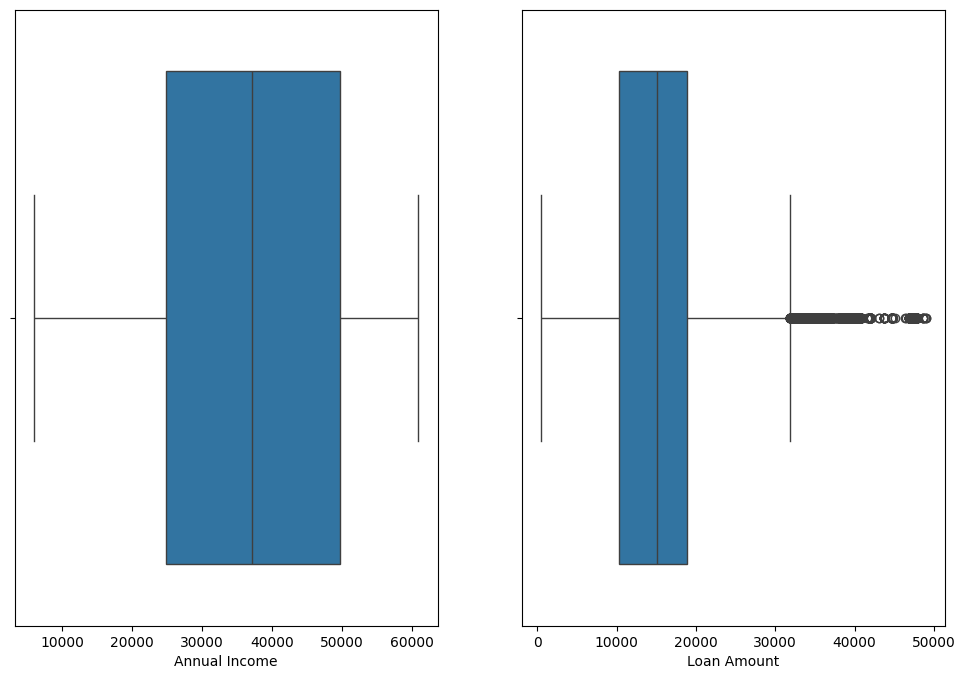

In [146]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=figsize)

sns.boxplot(not_outliers_data, x='Annual Income', ax=ax[0])
sns.boxplot(not_outliers_data, x='Loan Amount', ax=ax[1])

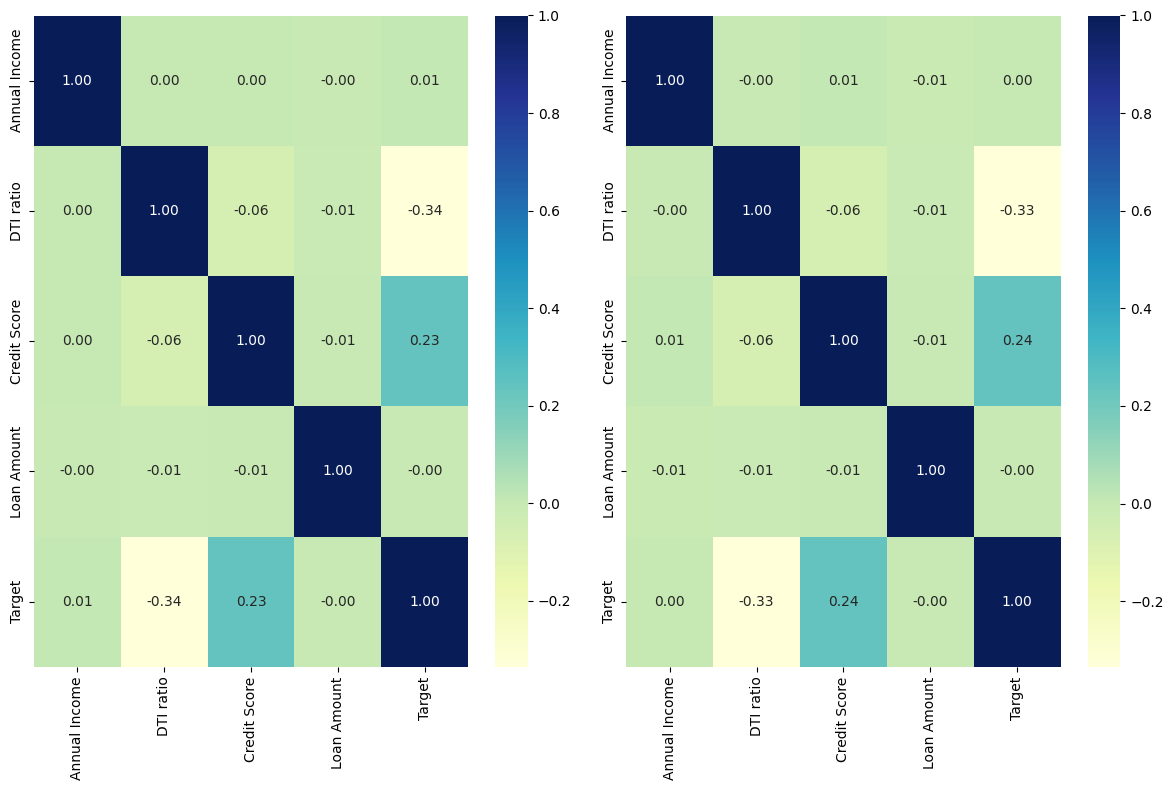

In [147]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=figsize)

numerical_data_not_outliers = not_outliers_data[['Annual Income', 'DTI ratio', "Credit Score", "Loan Amount"]]

df_not_outliers_income_corr = numerical_data_not_outliers.copy()
df_not_outliers_income_corr['Target'] = not_outliers_data['Loan Paid Back']
df_not_outliers_income_corr = df_not_outliers_income_corr.corr()

sns.heatmap(df_corr, annot=True, fmt='.2f', cmap="YlGnBu", ax=ax[0])
sns.heatmap(df_not_outliers_income_corr, annot=True, fmt='.2f', cmap="YlGnBu", ax=ax[1])

fig.tight_layout()

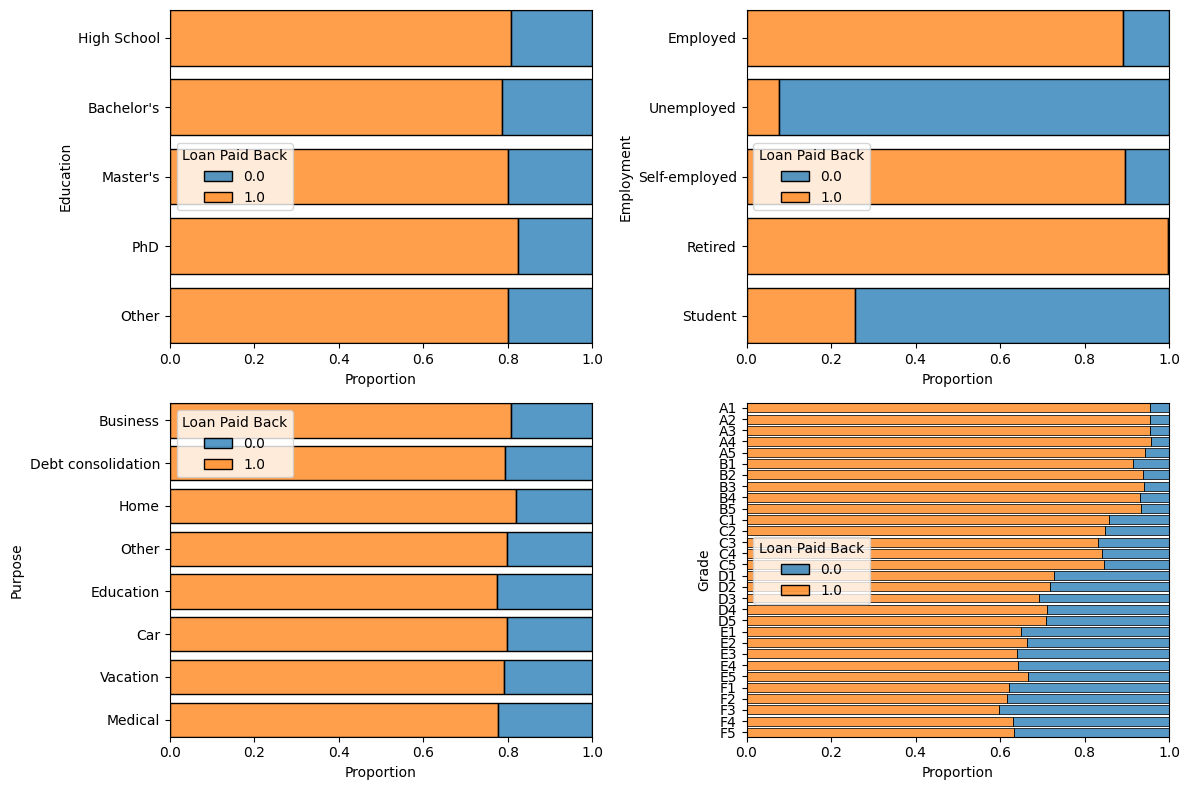

In [148]:
# Stacked Bar
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=figsize)

stacked_data = not_outliers_data.copy().sort_values(by='Grade')

sns.histplot(stacked_data, y='Education', hue='Loan Paid Back', multiple='fill', stat='proportion', discrete=True, shrink=.8, ax=ax[0, 0])
sns.histplot(stacked_data, y='Employment', hue='Loan Paid Back', multiple='fill', stat='proportion', discrete=True, shrink=.8, ax=ax[0, 1])
sns.histplot(stacked_data, y='Purpose', hue='Loan Paid Back', multiple='fill', stat='proportion', discrete=True, shrink=.8, ax=ax[1, 0])
sns.histplot(stacked_data, y='Grade', hue='Loan Paid Back', multiple='fill', stat='proportion', discrete=True, shrink=.8, ax=ax[1, 1])

fig.tight_layout()

In [149]:
not_outliers_data.describe()

,Annual Income,DTI ratio,Credit Score,Loan Amount,Loan Paid Back
count,445450.000000,445450.000000,445450.000000,445450.000000,445450.000000
mean,36774.574798,0.120841,680.991377,15028.521991,0.796177
std,14347.085592,0.069022,55.602595,6920.990935,0.402839
min,6002.430000,0.011000,395.000000,500.370000,0.000000
25%,24918.220000,0.072000,646.000000,10239.437500,1.000000
50%,37229.430000,0.096000,682.000000,15057.920000,1.000000
75%,49738.170000,0.156000,719.000000,18873.702500,1.000000
max,60981.230000,0.627000,849.000000,48959.950000,1.000000


##### D. Remove Outliers Loan Amount

In [154]:
q3_loan = not_outliers_data.describe()['Loan Amount']['75%'].item()
not_outliers_data = not_outliers_data.loc[not_outliers_data['Loan Amount'] < q3_loan]
not_outliers_data.describe()

,Annual Income,DTI ratio,Credit Score,Loan Amount,Loan Paid Back
count,250565.000000,250565.000000,250565.000000,250565.000000,250565.000000
mean,36929.905465,0.121147,681.254637,10203.406022,0.796771
std,14431.876316,0.069015,55.460782,4151.679517,0.402402
min,6008.560000,0.011000,440.000000,500.370000,0.000000
25%,24891.020000,0.072000,647.000000,7274.490000,1.000000
50%,37444.980000,0.096000,683.000000,11003.380000,1.000000
75%,49863.330000,0.157000,720.000000,13689.510000,1.000000
max,60981.230000,0.627000,849.000000,16013.250000,1.000000


<Axes: xlabel='Loan Amount'>

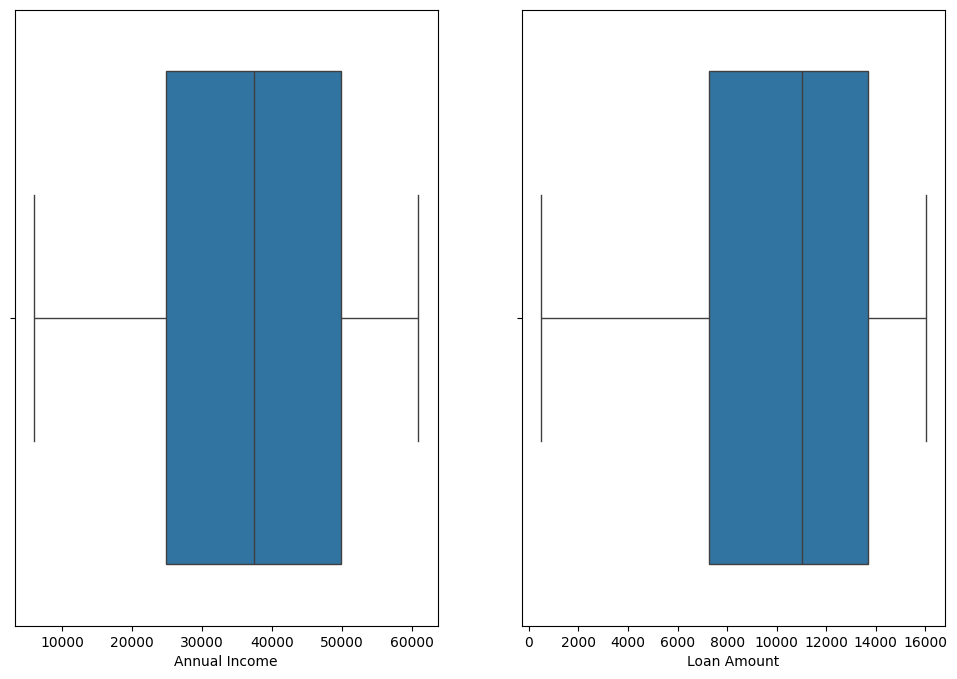

In [155]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=figsize)

sns.boxplot(not_outliers_data, x='Annual Income', ax=ax[0])
sns.boxplot(not_outliers_data, x='Loan Amount', ax=ax[1])

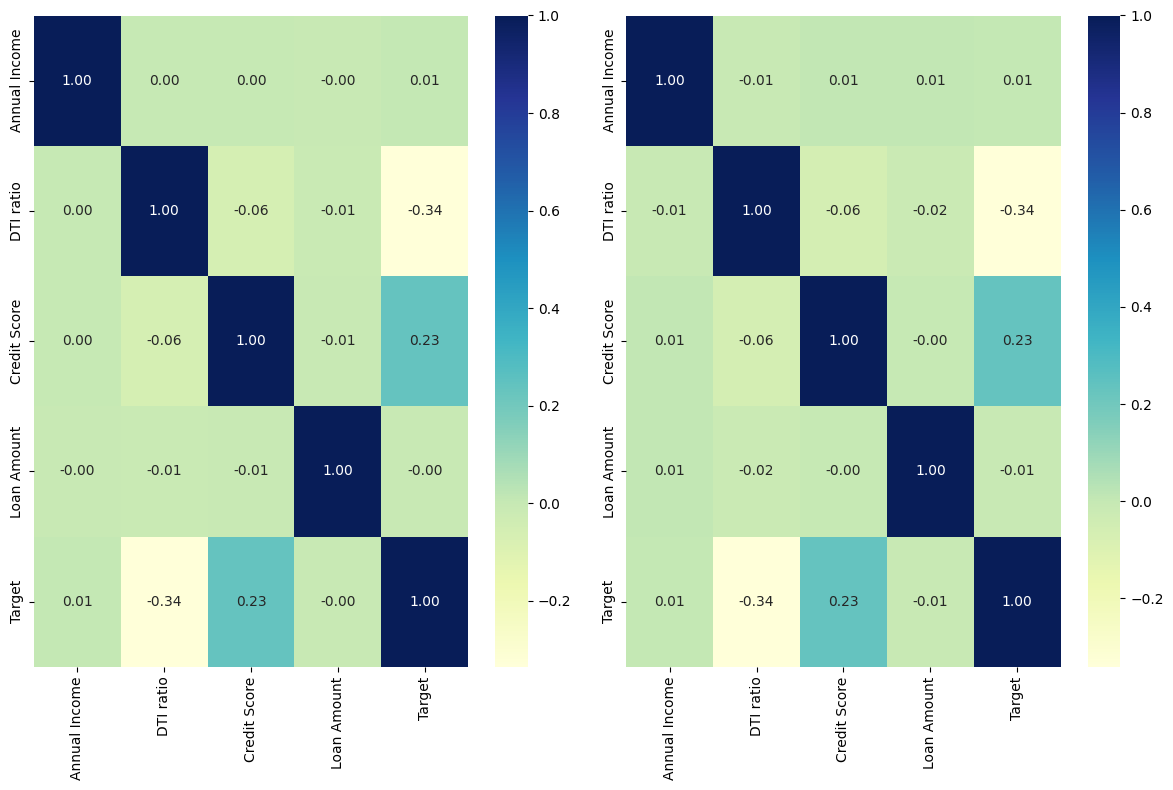

In [156]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=figsize)

numerical_data_not_outliers = not_outliers_data[['Annual Income', 'DTI ratio', "Credit Score", "Loan Amount"]]

df_not_outliers_income_corr = numerical_data_not_outliers.copy()
df_not_outliers_income_corr['Target'] = not_outliers_data['Loan Paid Back']
df_not_outliers_income_corr = df_not_outliers_income_corr.corr()

sns.heatmap(df_corr, annot=True, fmt='.2f', cmap="YlGnBu", ax=ax[0])
sns.heatmap(df_not_outliers_income_corr, annot=True, fmt='.2f', cmap="YlGnBu", ax=ax[1])

fig.tight_layout()

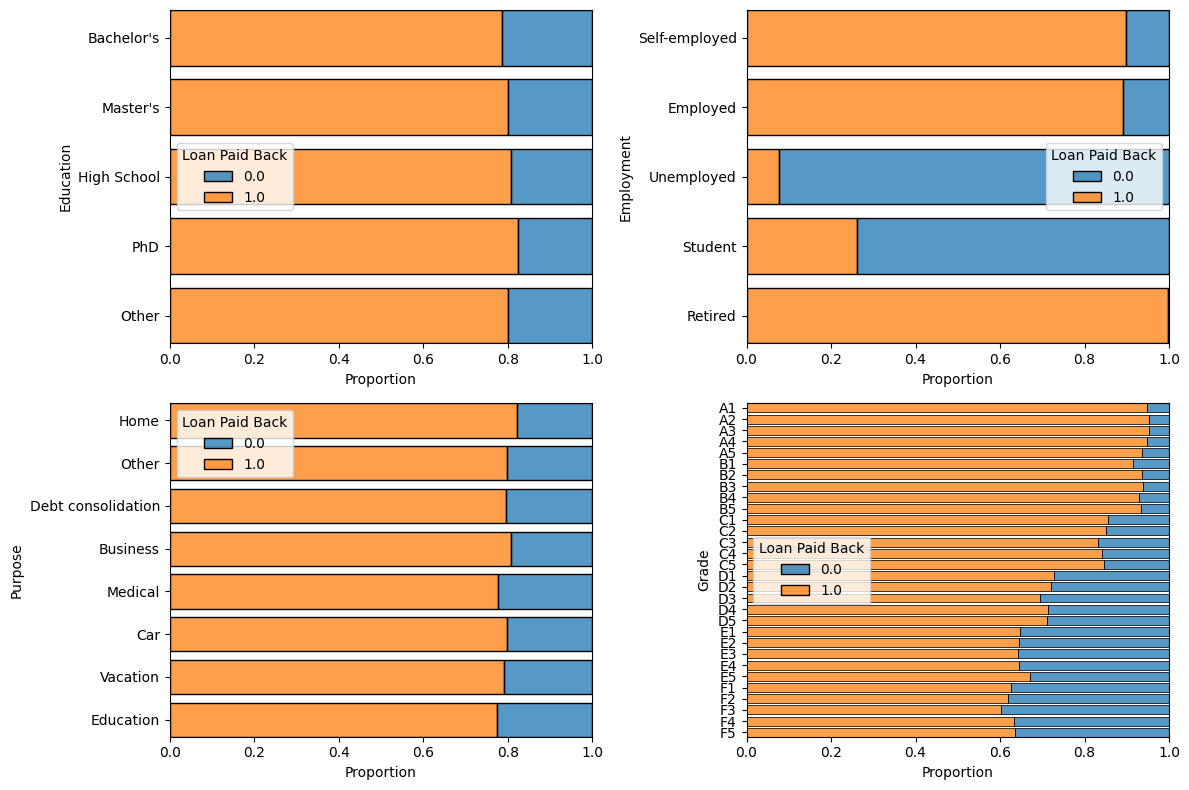

In [157]:
# Stacked Bar
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=figsize)

stacked_data = not_outliers_data.copy().sort_values(by='Grade')

sns.histplot(stacked_data, y='Education', hue='Loan Paid Back', multiple='fill', stat='proportion', discrete=True, shrink=.8, ax=ax[0, 0])
sns.histplot(stacked_data, y='Employment', hue='Loan Paid Back', multiple='fill', stat='proportion', discrete=True, shrink=.8, ax=ax[0, 1])
sns.histplot(stacked_data, y='Purpose', hue='Loan Paid Back', multiple='fill', stat='proportion', discrete=True, shrink=.8, ax=ax[1, 0])
sns.histplot(stacked_data, y='Grade', hue='Loan Paid Back', multiple='fill', stat='proportion', discrete=True, shrink=.8, ax=ax[1, 1])

fig.tight_layout()

## Tổng kết phần 5:
- đã xóa bỏ Outliers (vì dữ liệu cũng không bị thay đổi gì quá nhiều nên có thể bỏ ra)
- Chọn được các Feature quan trọng
    1. **DTI ratio**
    2. **Credit Score**
    3. **Employment**
    4. **Grade**
    5. **Loan/Income ratio**